In [3]:
import numpy as np
import scanpy
import phate
import scprep
import matplotlib.pyplot as plt
import magic
import leidenalg
import seaborn as sns
from sklearn.preprocessing import scale
import pandas as pd
import meld
from collections import defaultdict
import scipy

In [4]:
acute = scanpy.read_h5ad('data/acute_tcells.h5ad')
chronic = scanpy.read_h5ad('data/chronic_tcells.h5ad')

In [5]:
adata = scanpy.concat((acute,chronic))
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [6]:
phate_op = phate.PHATE(random_state=42, n_jobs=-1, knn=30, verbose=False)
adata.obsm['X_phate'] = phate_op.fit_transform(adata.to_df())

In [26]:
cmap = dict([(sample,plt.cm.Paired.colors[:6][i]) for i,sample in enumerate(['AcuteD4', 'ChronicD4', 'AcuteD8', 'ChronicD8', 'Acute40', 'Chronic40'])])

In [9]:
gene_embedding_results = np.load('results/GSPA_QR_without_regression.npz', allow_pickle=True)

In [10]:
data_ae = gene_embedding_results['signal_embedding']
localization = gene_embedding_results['localization_score']
hvgs = gene_embedding_results['genes']

In [13]:
gene_phate_op = phate.PHATE(random_state=0)
data_phate = gene_phate_op.fit_transform(data_ae)

Calculating PHATE...
  Running PHATE on 1416 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.23 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.28 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 2.54 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.24 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.46 seconds.
Calculated PHATE in 6.03 seconds.


<Axes: title={'center': 'Gene localization'}, xlabel='Gene PHATE1', ylabel='Gene PHATE2'>

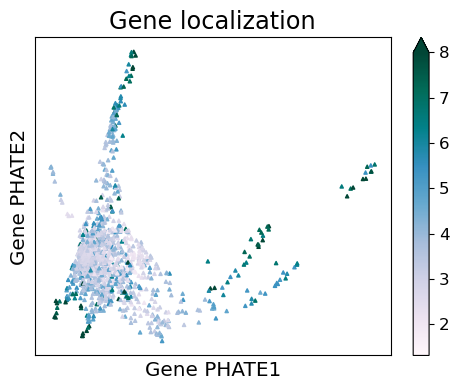

In [36]:
scprep.plot.scatter2d(data_phate, ticks=None, figsize=(5,4), c=localization, dpi=200, filename='figures/localization.png', vmax=8,
                          title='Gene localization', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^', cmap='PuBuGn')

In [15]:
gene_clusters = np.array(leidenalg.find_partition(gene_phate_op.graph.to_igraph(), 
                                                  leidenalg.ModularityVertexPartition,
                                                  seed=0).membership)
gene_clusters = pd.Series(gene_clusters, index=hvgs)

<Axes: title={'center': 'Gene clusters'}, xlabel='Gene PHATE1', ylabel='Gene PHATE2'>

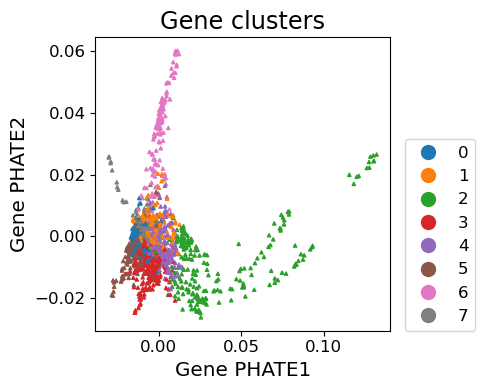

In [16]:
scprep.plot.scatter2d(data_phate, ticks=True, figsize=(5,4), c=gene_clusters, dpi=200, filename='figures/gene_8_clusters.png',
                          title='Gene clusters', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^')

<Axes: title={'center': 'Gene clusters'}, xlabel='Gene PHATE1', ylabel='Gene PHATE2'>

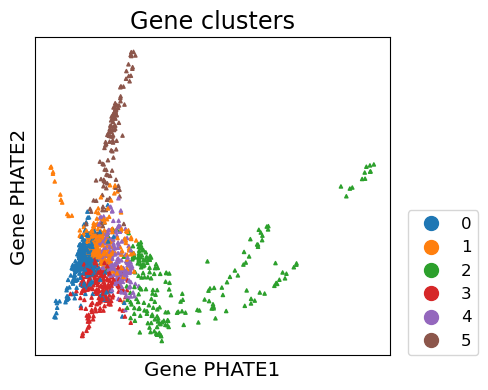

In [17]:
conv = {0:0, 1:1, 2:2, 3:3, 4:4, 5:0, 6:5, 7:1}
gene_clusters = [conv[x] for x in gene_clusters]
gene_clusters = pd.Series(gene_clusters, index=hvgs)
scprep.plot.scatter2d(data_phate, ticks=None, figsize=(5,4), c=gene_clusters, dpi=200, filename='figures/gene_clusters.png',
                          title='Gene clusters', label_prefix='Gene PHATE', legend_loc=(1.05,0), marker='^')

In [23]:
for module in range(gene_clusters.max() + 1):
    gene_list = gene_clusters[(gene_clusters == module)].index
    
    scanpy.tl.score_genes(adata, gene_list=gene_list,
                          random_state=0, score_name=f'GM_{module}_score',
                          gene_pool=hvgs, n_bins=int(len(hvgs) * 0.25))

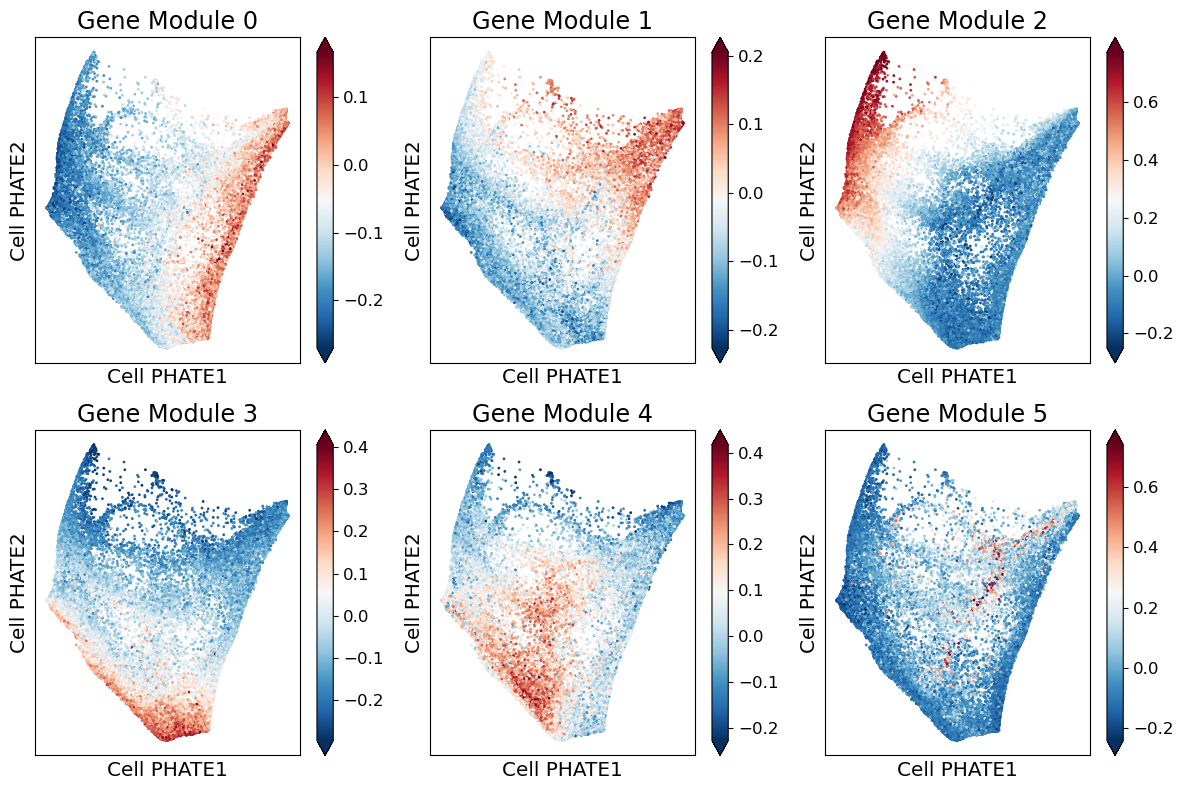

In [24]:
fig, ax = plt.subplots(2,3, figsize=(12,8), dpi=100); ax=ax.flatten()
for clust in range(gene_clusters.max() + 1):
    scprep.plot.scatter2d(adata.obsm['X_phate'], ax=ax[clust],
                          c=adata.obs[f'GM_{clust}_score'], cmap='RdBu_r',
                          vmax=np.percentile(adata.obs[f'GM_{clust}_score'], 99.9),
                          vmin=np.percentile(adata.obs[f'GM_{clust}_score'], 0.1),
                          title=f'Gene Module {clust}', ticks=None, label_prefix='Cell PHATE')

plt.tight_layout()
fig.savefig('figures/gene_cluster_enrichment.png', dpi=500)

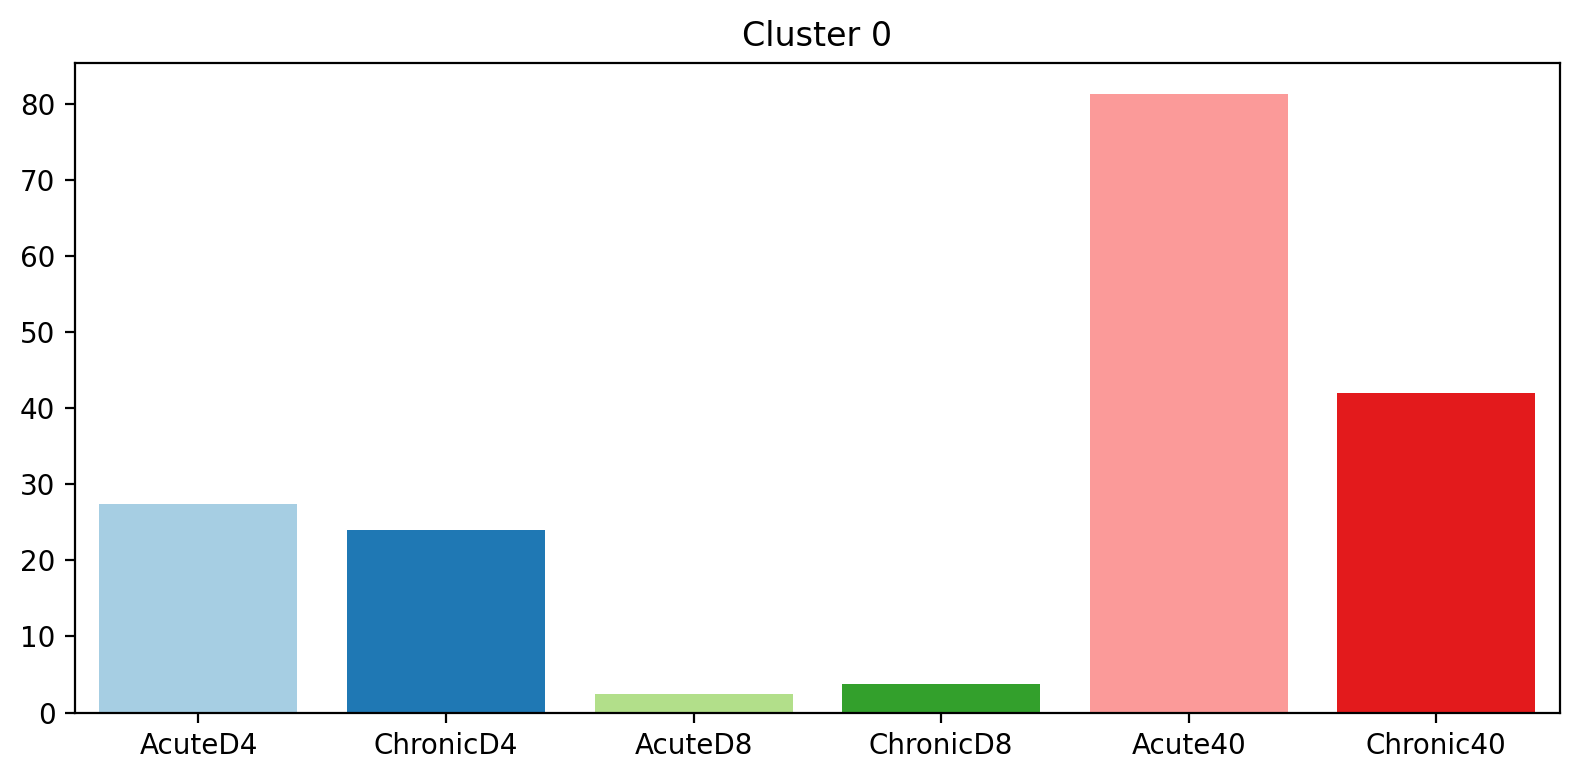

<Figure size 640x480 with 0 Axes>

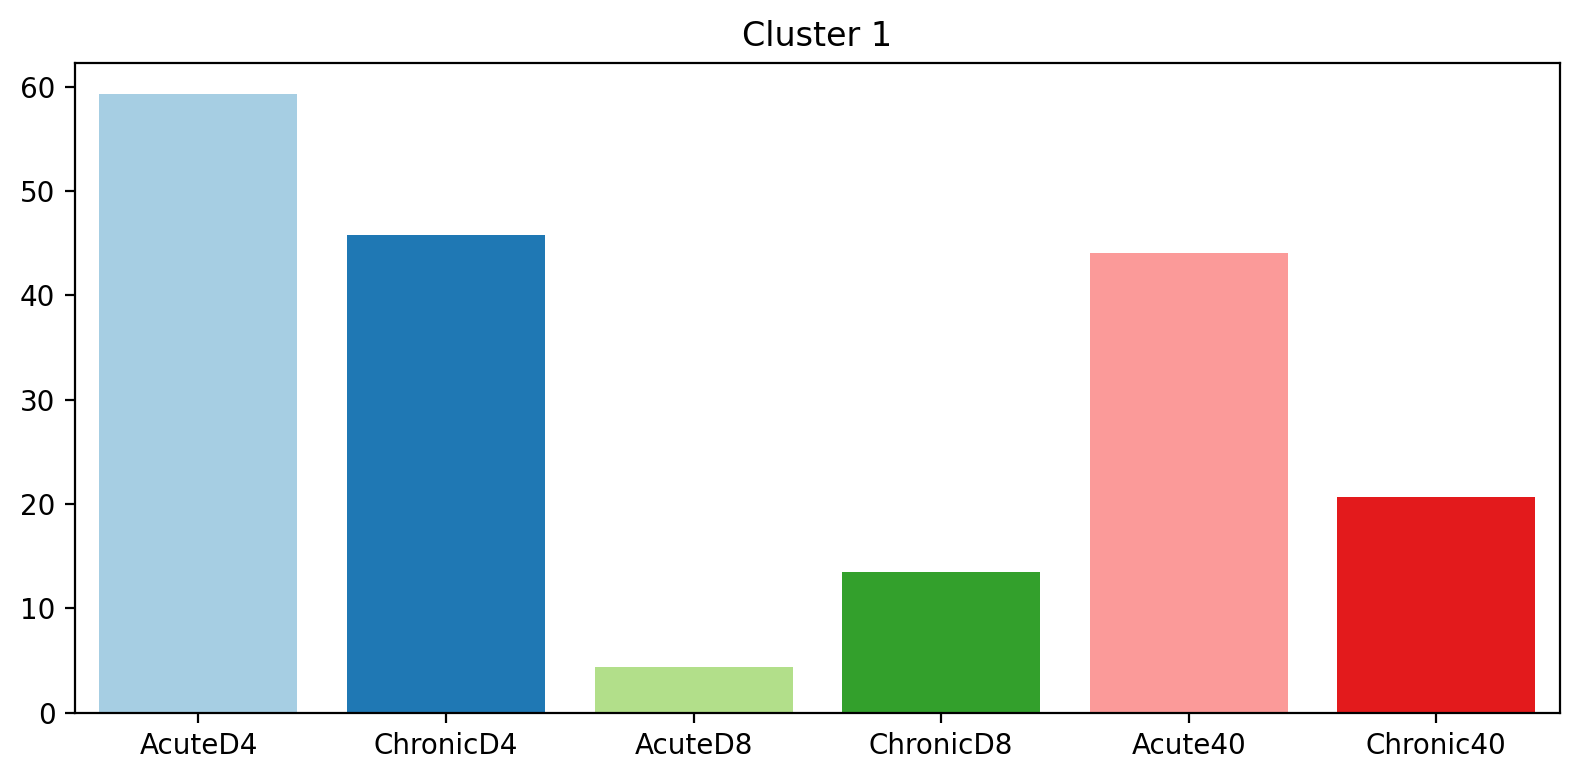

<Figure size 640x480 with 0 Axes>

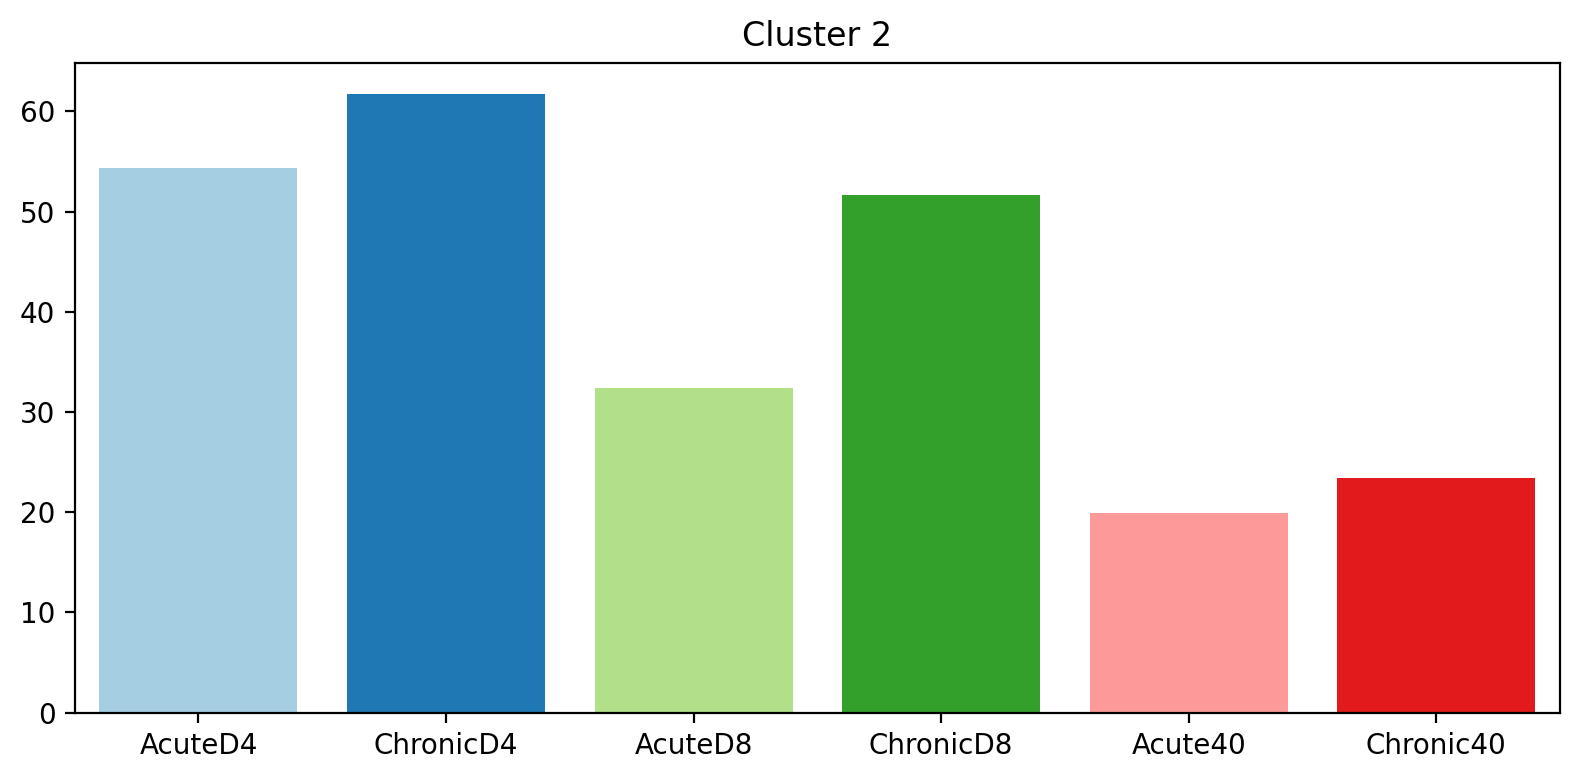

<Figure size 640x480 with 0 Axes>

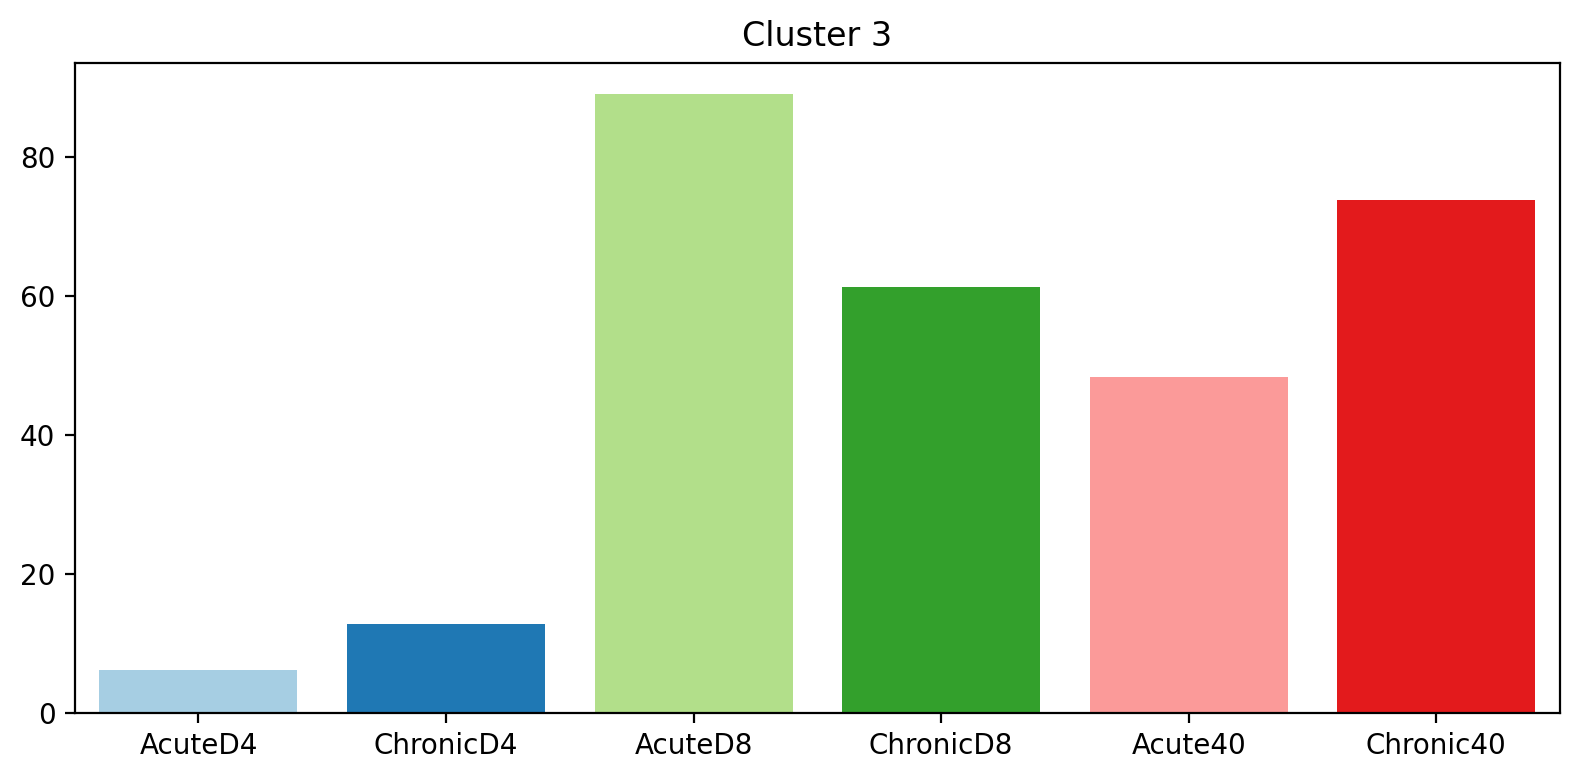

<Figure size 640x480 with 0 Axes>

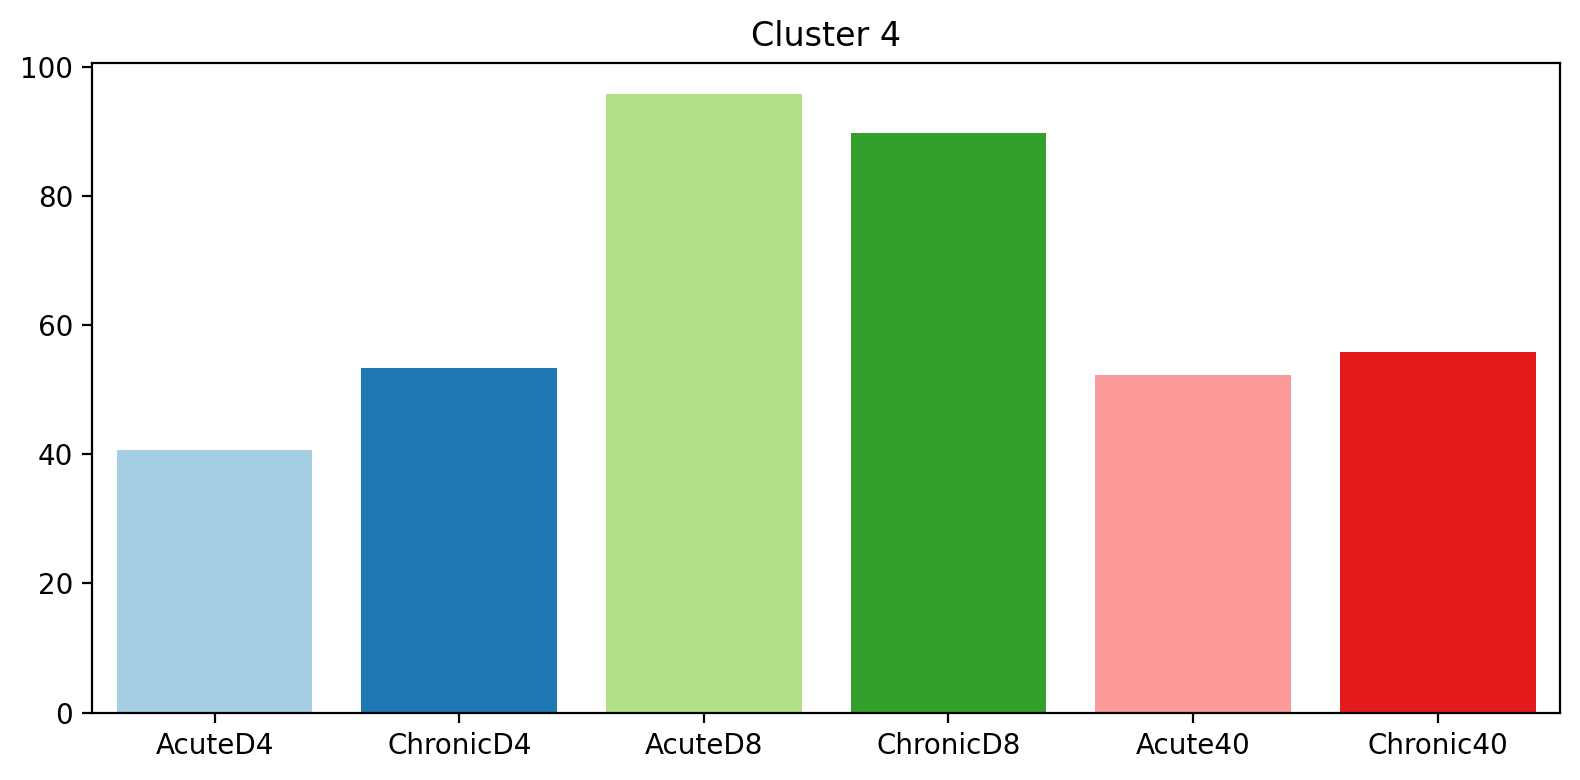

<Figure size 640x480 with 0 Axes>

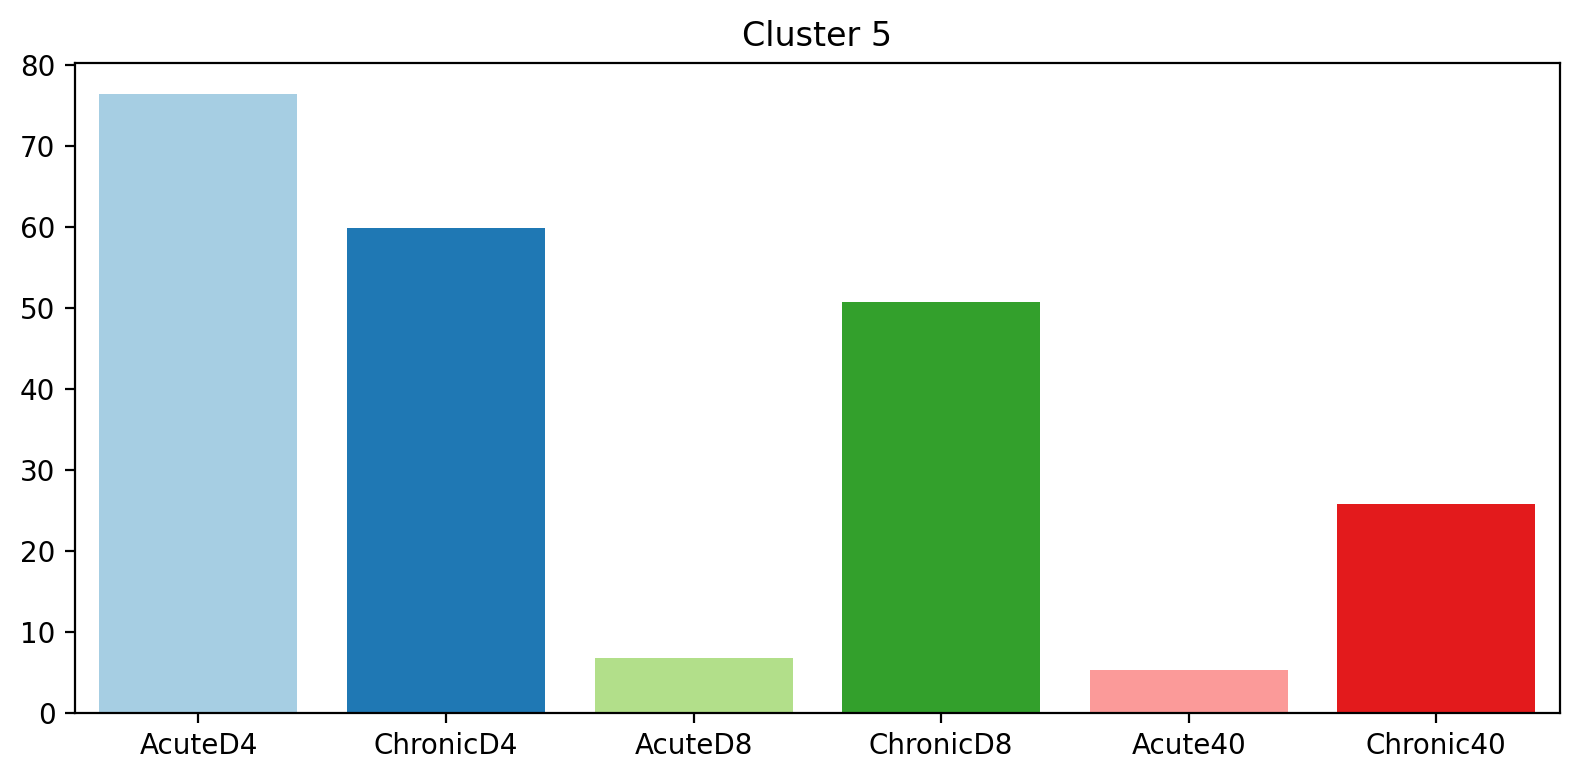

<Figure size 640x480 with 0 Axes>

In [27]:
for clust in range(gene_clusters.max() + 1):
    df = 100* adata.obs['batch'][adata.obs[f'GM_{clust}_score'] > 0.0].value_counts() / adata.obs['batch'].value_counts()
    df = df.loc[cmap.keys()]
    
    fig = plt.figure(figsize=(8,4), dpi=200)
    ax = sns.barplot(x=list(df.index), y=df.values)
    
    for i,name in enumerate(cmap.keys()):
        ax.patches[i].set_facecolor(cmap[name])
    
    plt.title(f'Cluster {clust}')
    plt.tight_layout()
    fig.savefig(f'figures/gene_cluster_{clust}_sample_proportion.png', dpi=200)
    plt.show(); plt.clf()

In [38]:
gene_summary = pd.DataFrame((gene_clusters.values.astype(str), localization)).T
gene_summary.columns = ['gene_clusters', 'localization_score']
gene_summary.index = hvgs
gene_summary.to_csv('results/gene_summary.csv')